In [1]:
from matplotlib import pyplot as plt
import xarray as xr
from tqdm import tqdm as progressbar
import numpy as np

import sys
sys.path.append('../McCreary')

from dynmodes import *

In [2]:
Nsq = np.load('Nsq.npy', allow_pickle=True)
depth = Nsq[1, :]
Nsq = Nsq[0, :]

In [3]:
from multimodemodel import MultimodeParameters
multimode_params = MultimodeParameters(z=depth, Nsq=Nsq, nmodes=49)

In [8]:
ds = multimode_params.as_dataset

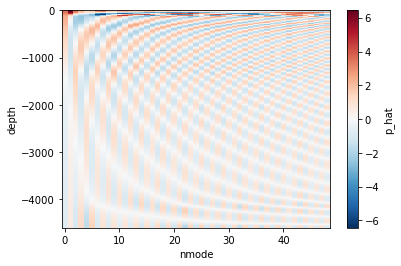

In [16]:
ds.p_hat.plot(x='nmode', y='depth')

In [18]:
A = 1.33e-7
gamma = A / ds.c.values**2

In [19]:
def tau(x, y):
    """"Wind field according to Mccreary (1980)."""
    delta_x = abs(x[0, 0] - x[0, -1]) / 2
    delta_y = abs(y[0, 0] - y[-1, 0]) / 2

    wind_x = np.cos(np.pi * x / delta_x)
    wind_x[abs(x) > delta_x / 2] = 0

    wind_y = (1 + y**2 / delta_y**2) * np.exp( - y**2 / delta_y**2)

    return -5e-6 * wind_x * wind_y

In [20]:
from  multimodemodel import StaggeredGrid

c_grid = StaggeredGrid.regular_lat_lon_c_grid(
    lon_start=-50.0,
    lon_end=50.0,
    lat_start=-5.0,
    lat_end=5.0,
    nx=100 * 4 + 1,
    ny=10 * 4 + 1,
    z = np.array([0])
)

In [39]:
from multimodemodel import Parameters, f_on_sphere
params = []
for i in range(multimode_params.nmodes):
    params.append(
        Parameters(
            coriolis_func=f_on_sphere(omega=7.272205e-05),
            on_grid=c_grid,
            H=np.array([ds.H.values[i]]),
            gamma = np.array([gamma[i]]),
        )
    )

In [40]:
from multimodemodel import (
    State, Variable,
 )
tau_x = np.expand_dims(tau(c_grid.u.x, c_grid.u.y), axis=0)
def zonal_wind(state, params):
    return State(u=Variable(tau_x /  params.rho_0, c_grid.u, np.datetime64("NaT")));

In [41]:
import functools as ft
import operator as op
from multimodemodel import (
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_v, linear_damping_u,
    linear_damping_eta
)

terms = [
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_v, linear_damping_u,
    linear_damping_eta, zonal_wind
]

def rhs(state, params):
    return ft.reduce(op.add, (term(state, params) for term in terms))

In [42]:
def save_as_Dataset(state: State, params: Parameters):
    w = (divergence_j(state, params) + divergence_i(state, params)).eta
    ds = state.variables["u"].as_dataarray.to_dataset(name='u_tilde')
    ds['v_tilde'] = state.variables["v"].as_dataarray
    ds['h_tilde'] = state.variables["eta"].as_dataarray
    ds['w_tilde'] = w.as_dataarray
    x = (["j", "i"], (state.u.grid.x + state.v.grid.x) / 2)
    y = (["j", "i"], (state.u.grid.y + state.v.grid.y) / 2)
    ds.assign_coords({"x": x, "y": y})
    return ds

In [43]:
from multimodemodel import integrate, adams_bashforth3

time = 365 * 24 * 3600.  # 1 year
step = c_grid.u.dx.min() / ds.c.values[1:].max() / 4.
t0 = np.datetime64("2000-01-01")

In [44]:
step = 1500

In [45]:
def run(params):
    model_run = integrate(
        State(
            u=Variable(None, c_grid.u, t0),
            v=Variable(None, c_grid.v, t0),
            eta=Variable(None, c_grid.eta, t0),
            q=Variable(None, c_grid.q, t0)
        ),
        params,
        RHS=rhs,
        scheme=adams_bashforth3,
        step=step,
        time=time,
    )
    
    Nt = time // step

    output = []

    for i, next_state in enumerate(model_run):
        if i % (Nt // 5) == 0:
            output.append(save_as_Dataset(next_state, params))
    
    
    return xr.combine_by_coords(output)

In [46]:
from multiprocessing import Pool

pool = Pool()
out = pool.map(run, params)

In [56]:
for i in range(len(out)):
    out[i]["nmode"] = np.array([i])
output = xr.combine_by_coords(out)

In [ ]:
output['u'] = xr.dot(ds.p_hat, output.u_tilde)
output['v'] = xr.dot(ds.p_hat, output.v_tilde)
output['w'] = xr.dot(ds.w_hat, output.w_tilde)
output['w_1e3'] = output.w * 1e3
output['h'] = xr.dot(ds.w_hat, output.h_tilde)

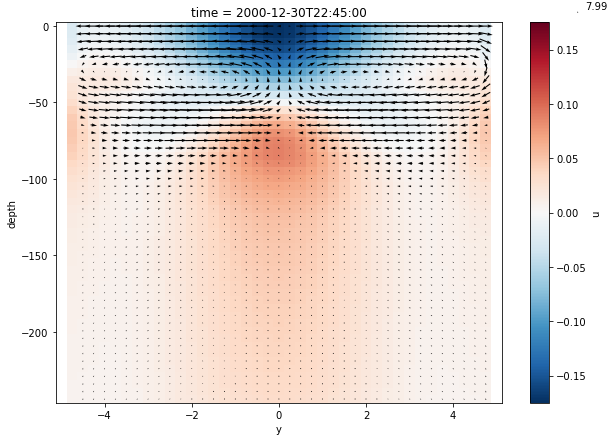

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
output.u.isel(i = 200, depth = slice(0,50), time=-1).plot.pcolormesh(x='y', y='depth', cmap='RdBu_r', ax = ax);
output.isel(i = 200, depth = slice(0,50), time=-1).plot.quiver(x='y', y='depth', u='v', v='w_1e3', ax = ax);
